# Quantitative Stock Selection

In [1]:
import yfinance as yf 

import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime
import math
from time import sleep
import quandl
import seaborn as sns
import sys
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import sys
import scipy.stats 
import ezodf
import scipy.optimize as sco
import scipy
import re
import os.path

/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Functions

In [ ]:
#SHORT INTEREST DATA

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium import webdriver 

# Change chromedriver path
driver = webdriver.Chrome('CHROMEDRIVER PATH')

driver.get("https://www.fi.se/sv/vara-register/blankningsregistret/")

df = pd.DataFrame(columns=['Company', 'Short interest %', 'Date'])

while(True):
    rows = driver.find_elements(By.XPATH, "//*[@role='row']")
    df1 = pd.DataFrame(columns=['Company', 'Short interest %', 'Date'])

    for r in rows:
        df2 = pd.DataFrame(columns=['Company', 'Short interest %', 'Date'])
        r = r.text.split()
        company = ""
        for i in range(len(r)-3):
            company += r[i] + " "
            df2.loc[0, 'Company'] = company.strip()
            df2.loc[0, 'Short interest %'] = r[len(r)-1]
            df2.loc[0, 'Date'] = r[len(r)-2]
        df1 = pd.concat([df1,df2])
    df1 = df1[1::]
    df = pd.concat([df,df1])
    try:
        driver.find_element(By.XPATH, "//*[@class='paginate_button next']").click()
    except:
        break
driver.quit()

In [2]:
# FUNCTIONS FOR VIEWING SINGLE COMPANY RANKINGS 

def company(company):
    for i in data['Company']:
        if company in i or company in i.lower():
            return data.loc[data['Company'] == i]
    print('No company found')
    
def Company(company):
    for i in data['Company']:
        if company in i or company in i.lower():
            stock = data.loc[data['Company'] == i]
            stock = stock[compact]
            return stock
    print('No company found')

In [3]:
def mod_Z_score(data):
    mean = np.mean(data.iloc[:-1])
    deviation_from_med = np.array(data.iloc[:-1]) - mean
    MAD = np.mean(np.abs(deviation_from_med))
    mod_Z = (data[-1:] - mean)/(MAD * 1.4826)
    return mod_Z

## Data Import and Wrangling

In [4]:
# IMPORT LATEST DATA 

path_import = "../equity_data/Borsdata_2022-02-26.xlsx"
data_tmp = pd.read_excel(path_import, sheet_name="Export")
data_tmp = data_tmp[1:]

data_tmp = data_tmp.rename({'Performance - Perform. 3m' : 'Return 3m','Performance - Perform. 6m' : 'Return 6m',
                            'Performance - Perform. 1y' : 'Return 1y',
                            'Div. Yield - Current': 'Yield', 
                            'Total Equity  - Millions':'Total Equity', 'FCF - Millions': 'FCF','ROE - Current':'ROE',
                            'Volatility - St.Dev. 100d':'Volatility','Market Cap - Current': 'Market Cap', 
                            'ROC - Current':'ROC', 'Tot. Assets - Millions':'Tot. Assets', 
                            'Gross profit - Millions':'Gross profit', 'Assets Turn - Current': 'Assets Turn',
                            'P/FCF - Current':'P/FCF', 'P/E - Current':'P/E', 'P/S - Current':'P/S',
                            'P/B - Current':'P/B','EV/EBIT - Current':'EV/EBIT',
                            'Info - Country' : 'Country','F-Score - Point':'F-Score',
                            'Info - List' : 'List', 'Info - Sector' : 'Sector', 'Info - Industry' : 'Industry',
                            'Info - Ticker' : 'Tick', 'Info - Yahoo':'Yahoo', 'Info - Last Report': 'Last Report',
                           'Volume - Average 50d Mill' : 'Volume'}, axis=1)

# FORMAT FOR VIEWING PLEASURE
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.options.display.float_format = "{:,.2f}".format

In [5]:
# MAKE NUMBERS FLOATS 

data_tmp['Market Cap'] = data_tmp['Market Cap'].replace(',', '') # remove , as 1000 separator

param_list = ['P/E', 'EV/EBIT', 'P/FCF', 'P/S', 'P/B', 'Assets Turn', 'Gross profit', 'Tot. Assets', 'ROC', 'Yield', 'Market Cap', 'Volatility', 'ROC', 'ROE', 'FCF', 'Total Equity', 
        'Return 3m', 'Return 6m', 'Return 1y']

for i in param_list: 
    data_tmp[i] = pd.to_numeric(data_tmp[i]) # make every number numeric


data_tmp['FCFROE'] = data_tmp['FCF']/data_tmp['Total Equity'] # calc FCFROE
data_tmp['GPA'] = data_tmp['Gross profit']/data_tmp['Tot. Assets'] 

In [6]:
# Manage negativ equity

data_tmp.loc[(data_tmp['Total Equity'] < 0), ['ROE', 'FCFROE', 'P/B']] = np.nan


In [7]:
### FILTER DATA FOR VOLUME, LIST AND MARKET CAP

data_tmp = data_tmp.loc[data_tmp['Market Cap'] > 400] #Market cap filter


data_tmp = data_tmp.loc[ (data_tmp['List'] != 'Spotlight') 
                        & (data_tmp['List'] != 'NGM')]

#Volume Filter
data_tmp = data_tmp.loc[data_tmp['Volume'] > 0.5] 

# Set to dattime
data_tmp['Last Report'] = pd.to_datetime(data_tmp['Last Report'])

#set new index
data_tmp.index = range(len(data_tmp.index))

In [8]:
print("Companies in data: ",len(data_tmp))
print("Missing Report Dates: ",sum(data_tmp['Last Report'].isna()))


Companies in data:  457
Missing Report Dates:  13


In [9]:
### Sector
data_tmp.groupby('Sector').mean()['Return 3m']

Sector
Consumer Durables   -0.14
Energy               0.19
Financials          -0.19
Food and Beverage   -0.21
Health Care         -0.22
Industrials         -0.16
Materials            0.04
Technology          -0.20
Telecom             -0.11
Utilities           -0.28
Name: Return 3m, dtype: float64

In [10]:
#data_tmp.groupby("Sector")["Return 3m"].transform('mean')

In [11]:
#data_tmp

In [12]:
data_tmp.groupby('Sector').size()

Sector
Consumer Durables    70
Energy                9
Financials           90
Food and Beverage    16
Health Care          71
Industrials          95
Materials            24
Technology           62
Telecom               7
Utilities            13
dtype: int64

## Calculate Price Based Data from Yahoo Finance

In [13]:
## Get PEAD
START_DATE = '2018-01-01'

data_tmp["EA ret"] = np.nan
data_tmp["EA ret std"] = np.nan
data_tmp['1 Year Volatility'] = np.nan
data_tmp['1 Year MAD'] = np.nan
data_tmp['1 Month Return'] = np.nan
data_tmp['EA Volatility'] = np.nan
data_tmp['Beta'] = np.nan
data_tmp['Res_Mom_1Y'] = np.nan
data_tmp['Res_Mom_6m'] = np.nan

index = yf.download('^OMXSPI',start=START_DATE, threads = False, progress = False)
index = index['Close']

error_count = 0
error_list = []

In [14]:
for i in range(len(data_tmp)):
    try:
        stock = yf.download(data_tmp.iloc[i]['Yahoo'],start=START_DATE, progress = False, threads = False)
        stock = stock['Adj Close']
        import_data = pd.concat([stock, index], axis = 1)
        import_data.columns = ['stock', 'index']
        import_data = import_data.dropna()
        
        # get index of date of report
        idx = import_data.index.get_loc(data_tmp.iloc[i]['Last Report'], method='nearest')
        EA_data = import_data.iloc[idx - 2 : idx +2 ]
        
        stock_idx = stock.index.get_loc(data_tmp.iloc[i]['Last Report'], method='nearest')
        
        EA_ret = (EA_data.pct_change().dropna()+1).cumprod().tail(1)
        pead_ret = float(EA_ret['stock'] - EA_ret['index'])
        data_tmp.loc[i,"EA ret"]= pead_ret
        
        data_tmp.loc[i,"1 Month Return"]= float((stock.pct_change().tail(5).dropna()+1).cumprod().tail(1)) - 1
        
        data_tmp.loc[i, 'EA Volatility'] = np.log(stock.iloc[:idx]/stock.iloc[:idx].shift()).tail(60).std()*252**.5 
        #Get MAD of stock
        data_tmp.loc[i,"1 Year MAD"]= np.log(stock/stock.shift()).tail(252).mad()*252**.5*1.25
        # Get volatility of stock
        data_tmp.loc[i,"1 Year Volatility"]= np.log(stock/stock.shift()).tail(252).std()*252**.5 
        
        
        ### BETA AND RESIDUAL MOMENTUM, USE STATSMODELS INSTEAD??
        long_df = import_data.copy()
        long_df = long_df.resample('m').last()
        ret_df = np.log(long_df/long_df.shift()).dropna()
        reg_df = ret_df.tail(36)
        if len(reg_df) == 36:
            y = reg_df['stock']
            X = np.array(reg_df['index']).reshape(-1, 1)
            reg = LinearRegression().fit(X, y)
            beta = reg.coef_[0]
            residuals = y - reg.predict(X)
            res_mom_1Y = residuals.tail(12).sum()/residuals.tail(12).std()
            res_mom_6m = residuals.tail(6).sum()/residuals.tail(6).std()
            data_tmp.loc[i,"Beta"] = beta
            data_tmp.loc[i,"Res_Mom_1Y"] = res_mom_1Y
            data_tmp.loc[i,"Res_Mom_6m"] = res_mom_6m
       
    except:
        #data_tmp.loc[i,"EA ret"]= np.nan
        #print("ERROR! INDEX: ", i, ', TICKER: ', data_tmp.iloc[i]['Yahoo'])
        error_count = error_count + 1
        error_list.append(i)
    
    


1 Failed download:
- FLAT-B-ST: No data found, symbol may be delisted

1 Failed download:
- SPLTN.ST: No data found, symbol may be delisted

1 Failed download:
- SDIP.ST: No data found, symbol may be delisted


In [15]:
### NA ANALYTICS
print("Amount of Errors: ",error_count )
print("Missing EA rets: ",sum(data_tmp["EA ret"].isna()) )
print("Missing EA volatility: ",sum(data_tmp["EA Volatility"].isna()) )
print("Missing 1 Year volatility: ",sum(data_tmp["1 Year Volatility"].isna()) )

Amount of Errors:  16
Missing EA rets:  16
Missing EA volatility:  16
Missing 1 Year volatility:  16


In [17]:
## Show errors
data_tmp[data_tmp['EA ret'].isna()][['Company', 'Yahoo', 'Last Report', 'EA ret']]

,Company,Yahoo,Last Report,EA ret
5,Acast,ACAST.ST,2022-02-11,-0.00
7,ACQ Bure SPAC,ACQ-SPAC.ST,2022-02-17,0.04
11,Advanced SolTech,ASAB.ST,2022-02-24,0.05
18,Aligro Planet SPAC,APAC-SPAC-A.ST,NaT,NaN
24,Annehem Fastigheter,ANNE-B.ST,2021-10-29,0.04
31,Aros Bostadsutveckling,AROS.ST,2021-11-26,0.06
80,Byggfakta,BFG.ST,NaT,NaN
87,Careium,CARE.ST,2022-02-17,-0.18
88,Cary Group,CARY.ST,2022-02-11,-0.04
89,Case Group,CASE.ST,NaT,NaN


### TESTING TICKERS ONCE AGAIN, RE ENTER FAILED TICKERS BY HAND

In [91]:
##### TESTING TICKERS ONCE AGAIN, RE ENTER FAILED TICKERS BY HAND #####
j = None
if j != None:
    stock = yf.download(data_tmp.iloc[j]['Yahoo'],start='2018-01-01', progress = False, threads = False)
    stock = stock['Adj Close']
    import_data = pd.concat([stock, index], axis = 1)
    import_data.columns = ['stock', 'index']
    import_data = import_data.dropna()

    # get index of date of report
    idx = import_data.index.get_loc(data_tmp.iloc[j]['Last Report'], method='nearest')
    EA_data = import_data.iloc[idx - 2 : idx +2 ]

    stock_idx = stock.index.get_loc(data_tmp.iloc[j]['Last Report'])

    EA_ret = (EA_data.pct_change().dropna()+1).cumprod().tail(1)
    pead_ret = float(EA_ret['stock'] - EA_ret['index'])
    data_tmp.loc[j,"EA ret"]= pead_ret
    data_tmp.loc[j, 'EA Volatility'] = np.log(stock.iloc[:idx]/stock.iloc[:idx].shift()).tail(60).std()*252**.5 
    #Get MAD of stock
    data_tmp.loc[j,"1 Year MAD"]= np.log(stock/stock.shift()).tail(252).mad()*252**.5*1.25
    # Get volatility of stock
    data_tmp.loc[j,"1 Year Volatility"]= np.log(stock/stock.shift()).tail(252).std()*252**.5 
    
    
    ### BETA AND RESIDUAL MOMENTUM
    long_df = import_data.copy()
    long_df = long_df.resample('m').last()
    ret_df = np.log(long_df/long_df.shift()).dropna()
    reg_df = ret_df.tail(36)
    y = reg_df['stock']
    X = np.array(reg_df['index']).reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    beta = reg.coef_[0]
    residuals = y - reg.predict(X)
    res_mom = residuals.tail(12).sum()/residuals.tail(12).std()
    
    

In [21]:
data_tmp.sort_values(by='Res_Mom_6m', ascending=False)[['Company', 'EA ret', 'Res_Mom_1Y','Res_Mom_6m', 'Beta']].head(30)


,Company,EA ret,Res_Mom_1Y,Res_Mom_6m,Beta
134,Electrolux B,-0.02,-0.18,8.84,1.54
68,Boliden,0.04,3.65,7.70,0.83
234,Josemaria Resources,-0.04,8.32,7.66,0.84
67,Björn Borg,0.10,12.42,7.65,1.81
49,Beijer Alma,0.03,6.18,7.30,1.55
39,Autoliv,-0.02,2.60,6.71,1.42
204,Husqvarna B,-0.02,-0.63,5.55,1.47
206,I.A.R Systems,0.04,2.88,5.50,0.97
165,Filo Mining,0.10,4.85,5.43,1.17
372,Serneke,0.01,5.76,5.25,1.68


In [22]:
data_tmp[data_tmp['Company'] == 'Poolia']

,Börsdata ID,Company,Industry,Volume,P/FCF,Assets Turn,Gross profit,Tot. Assets,ROC,Market Cap,Volatility,ROE,FCF,Total Equity,Return 3m,Return 6m,Total Return - Return 1y,Country,List,Tick,EV/EBIT,Last Report,Yahoo,Return 1y,Yield,P/E,P/S,P/B,Tot. Assets - Growth 1y,Info - Stock price,Info - Report,Sector,FCFROE,GPA,EA ret,EA ret std,1 Year Volatility,1 Year MAD,1 Month Return,EA Volatility,Beta,Res_Mom_1Y,Res_Mom_6m
332,177,Poolia,Outsourcing,2.42,7.16,2.99,162.10,636.80,0.97,762.51,48.06,0.38,106.50,212.70,-0.01,0.26,1.67,Sweden,Small Cap,POOL B,6.59,2022-02-22,POOL-B.ST,1.52,0.06,9.46,0.40,3.58,0.28,2022-02-25,Q4-2021,Industrials,0.50,0.25,0.03,NaN,0.47,0.44,0.04,0.53,1.61,4.94,3.13


### Handel NANs

In [24]:
# MANAGE NaNs and NEGATIVE EARNINGS  
# set nan to min
for i in ['Return 3m', 'Return 6m', 'Return 1y', 'Res_Mom_1Y', 'Res_Mom_6m']:
    data_tmp.loc[data_tmp[i].isna() ,i] = data_tmp[i].min()
    
data_tmp.loc[data_tmp['Volatility'].isna(),'Volatility'] = data_tmp['Volatility'].median()

data_tmp.loc[data_tmp['EA ret'].isna(),'EA ret'] = data_tmp['EA ret'].median()
data_tmp.loc[data_tmp['EA Volatility'].isna(),'EA Volatility'] = data_tmp['Volatility'].median()/100

#Impute 100 day volatility for NANs
data_tmp.loc[data_tmp['1 Year Volatility'].isna(),'1 Year Volatility'] = data_tmp.loc[data_tmp['1 Year Volatility'].isna(),'Volatility']/100

#Impute median for NAN MAD
data_tmp.loc[data_tmp['1 Year MAD'].isna(),'1 Year MAD'] = data_tmp['1 Year MAD'].median()

In [26]:
## Impute EA std and calculate EA STD after everything has been imputed
data_tmp["EA ret std"] = data_tmp["EA ret"]/((data_tmp["EA Volatility"]*np.sqrt(3))/np.sqrt(252))

#Impute median for NAN EA STD
data_tmp.loc[data_tmp['EA ret std'].isna(),'EA ret std'] = data_tmp['EA ret std'].median()

In [27]:
### SAVE cleaned file into a CSV
save = "NO"
if save == "YES":
    data_date  = re.search(r'\d{4}-\d{2}-\d{2}', path_import)
    folder = 'clean_equity_data'
    exp_file_name = "clean_equity_data_{}".format(data_date.group(0))+ ".csv"
    data_tmp.to_csv(os.path.join(folder, exp_file_name))

# DATA handling



In [28]:
####### FILTER DATA FOR SUB STRATEGIES
data_full = data_tmp.copy()
### MOMENTUM
data_mom = data_tmp.copy()
data_mom = data_mom.loc[(data_mom['Industry'] != 'Holding Companies')]
#data_mom = data_tmp.loc[(data_tmp['Sector'] != 'Financials')]

data = data_tmp.copy()
### GESTALT
data = data.loc[(data_tmp['Sector'] != 'Financials')]

## MOMENTUM


In [31]:
# RANK ON DIFFERENT METRICS 

data_mom['3m Rank'] = data_mom['Return 3m'].rank(ascending = False)
data_mom['6m Rank'] = data_mom['Return 6m'].rank(ascending = False)
data_mom['1y Rank'] = data_mom['Return 1y'].rank(ascending = False)
data_mom['1y Res Mom Rank'] = data_mom['Res_Mom_1Y'].rank(ascending = False)


data_mom['EA Rank'] = data_mom['EA ret'].rank(ascending = False)
data_mom['EA Std Rank'] = data_mom['EA ret std'].rank(ascending = False)
data_mom['Volatility Rank'] = data_mom['1 Year Volatility'].rank(ascending = True)
data_mom['MAD Rank'] = data_mom['1 Year Volatility'].rank(ascending = True)

# MOMENTUM WITH VOLATILITY
#data_mom['Momentum Rank'] = (data_mom['Return 3m'].rank(ascending = False) + data_mom['Return 6m'].rank(ascending = False) + 
#                              data_mom['Return 1y'].rank(ascending = False) + data_mom['Volatility'].rank(ascending = True)).rank(ascending = True)

# PURE MOMENTUM
#data_mom['Momentum Rank'] = (data_mom['Return 3m'].rank(ascending = False) + data_mom['Return 6m'].rank(ascending = False) + 
#                              data_mom['Return 1y'].rank(ascending = False)).rank(ascending = True)

# MOMENTUM WITH WOLATILITY AND EA
data_mom['Momentum Rank'] = (data_mom['3m Rank'] + data_mom['6m Rank'] +  data_mom['1y Rank'] + data_mom['Volatility Rank'] + data_mom['EA Std Rank']).rank(ascending = True)

## GESTALT

In [32]:
# MANAGE NaNs and NEGATIVE EARNINGS  

# set nan to median, only fundamental data
columns = ['P/E', 'EV/EBIT', 'P/FCF', 'P/S', 'P/B', 'ROC', 'ROE',
            'GPA', 'Assets Turn', 'FCFROE']
for i in columns: 
    data.loc[data[i].isna() ,i] = data[i].median()

# set nan to min
#for i in ['Return 3m', 'Return 6m', 'Return 1y']:
#    data.loc[data[i].isna() ,i] = data[i].min()
    
# set negative values to max
for i in ['P/E', 'EV/EBIT', 'P/FCF', 'P/S', 'P/B']:
    data.loc[data[i] < 0 ,i] = data[i].max()
    
# set nan yield & vol to 0
data.loc[data['Yield'].isna(),'Yield'] = 0

In [33]:
#data_mom.isna().sum()

### Test

In [34]:
#data['1m Rank'] = data['1 Month Return'].rank(ascending = True,pct=True) #high rank means high return
#data['Sector Rank'] = data['Sector Mom'].rank(ascending = False,pct=True) # Low rank means high return

#comb rank, high is good

#low means strong sector, weak stocks = buy
#data['High Freq Combo'] = (data['1m Rank'] + data['Sector Rank']).rank(ascending = False,pct=True) 

## Rankings and Sorting

In [35]:
# RANK ON DIFFERENT METRICS 


data['3m Rank'] = data['Return 3m'].rank(ascending = False)
data['6m Rank'] = data['Return 6m'].rank(ascending = False)
data['1y Rank'] = data['Return 1y'].rank(ascending = False)
data['EA Rank'] = data['EA ret'].rank(ascending = False)
data['EA Std Rank'] = data['EA ret std'].rank(ascending = False)


data['Momentum Rank'] = (data['3m Rank'] + data['6m Rank'] + data['1y Rank'] + data['EA Std Rank']).rank(ascending = True)

#data['Momentum'] = (data['Return 3m'] + data['Return 6m'] + data['Return 1y'])

# Ranking where lower value is better
for i in ['P/E', 'P/B', 'P/S', 'P/FCF', 'EV/EBIT']:
    data[i +' Rank'] = data[i].rank()
    
# Ranking where higher value is better
#for i in ['Yield', 'ROE', 'ROC', 'FCFROE', 'Momentum', 'GPA', 'Assets Turn']:
for i in ['Yield', 'ROE', 'ROC', 'FCFROE', 'GPA', 'Assets Turn']:
    data[i + ' Rank'] = (-data[i]).rank()
    
# Composite ranks
data['Quality Rank'] = (data['ROE Rank'] + data['ROC Rank'] + data['FCFROE Rank'] + 
                        data['GPA Rank'] + data['Assets Turn Rank']).rank()
data['Value Rank'] = (data['P/E Rank'] + data['P/B Rank'] + data['P/S Rank'] + data['P/FCF Rank'] + 
                      data['EV/EBIT Rank'] + data['Yield Rank']).rank()
 
data['Magic Formula'] = (data['ROC Rank'] + data['EV/EBIT Rank']).rank()
data['Siegfrieds'] = (data['ROC Rank'] + data['P/B Rank']).rank()
data['Triple Sort'] = ((data['Value Rank'] + data['Momentum Rank'] + data['Quality Rank'])).rank()
data['Double Sort'] = (data['Value Rank'] + data['Quality Rank']).rank()

In [36]:
# SORTING 

# number of stocks to choose before momentum screen
trend_screen = 40
double_sort_break_off = 40

value_tmp = data.sort_values(by=['Value Rank'])
quality_tmp = data.sort_values(by=['Quality Rank'])
#### MOMENTUM DATA FRAME
momentum_tmp = data_mom.sort_values(by=['Momentum Rank'])


trending_value_tmp = value_tmp[0:trend_screen]
trending_value_tmp = trending_value_tmp.sort_values(by='Momentum Rank')
trending_quality_tmp = quality_tmp[0:trend_screen]
trending_quality_tmp = trending_quality_tmp.sort_values(by='Momentum Rank')
magic_formula_tmp = data.sort_values(by=['Magic Formula'])
siegfrieds_tmp = data.sort_values(by=['Siegfrieds'])
triple_sort_tmp = data.sort_values(by=['Triple Sort'])
double_sort = data.sort_values(by=['Double Sort'])
double_sort_mom_tmp = double_sort[0:double_sort_break_off]
double_sort_mom = double_sort_mom_tmp.sort_values(by=['Momentum Rank'])

In [37]:
# FACTOR STRATEGIES 

compact = ['Company', 'List','Tick', 'Quality Rank', 'Value Rank', 'Momentum Rank', 'EA Std Rank', '1 Year Volatility', 'Res_Mom_1Y', 'Res_Mom_6m']
compact_mom = ['Company', 'List','Tick', 'Momentum Rank','Volatility Rank','EA Std Rank', '1 Year Volatility', 'Res_Mom_1Y','Res_Mom_6m']

# numbers of stocks to select for diff strategies

stocks = 20
magic_formula_stocks = 10
siegfried_stocks = 10
triple_sort_stocks = 20
double_sort_mom_stocks = 10

## VALUE ## 
value = value_tmp[0:stocks]
Value = value[compact]

## QUALITY ## 
quality = quality_tmp[0:stocks]
Quality = quality[compact]

## MOMENTUM ##
momentum = momentum_tmp[0:stocks]
Momentum = momentum[compact_mom]

## TRENDING VALUE ##
trending_value = trending_value_tmp[0:stocks]
Trending_Value = trending_value[compact]

## TRENDING QUALITY ##
trending_quality = trending_quality_tmp[0:stocks]
Trending_Quality = trending_quality[compact]

## MAGIC FORMULA ##
magic_formula = magic_formula_tmp[0:magic_formula_stocks]
Magic_Formula = magic_formula[compact]

## SIEGFRIEDS ##
siegfrieds = siegfrieds_tmp[0:siegfried_stocks]
Siegfrieds = siegfrieds[compact]

## TRIPLE SORT ##
triple_sort = triple_sort_tmp[0:triple_sort_stocks]
Triple_Sort = triple_sort[compact]

## DOUBLE SORT + Momentum ##
double_sort_mom = double_sort_mom[0:double_sort_mom_stocks]
Double_Sort_Mom = double_sort_mom[compact]

In [38]:
company('Samhallsbyggnadsbolag B')

No company found


## Print Stock Selection

In [40]:
#Triple_Sort 
th_props = [
  ('font-size', '14px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]
# Set CSS properties for td elements in dataframe
td_props = [('font-size', '12px'), ('text-align', 'center')]
#set caption props
caption_props = [('color', 'black'),('font-size', '22px'),
        ("text-align", "center"),
        ('font-weight', 'bold')]
# Set table styles
styles = [
    dict(selector="th", props=th_props),
    dict(selector="td", props=td_props),
    dict(selector="caption", props=caption_props)
]
Triple_Sort.index = range(1, len(Triple_Sort)+1)
Triple_Sort_view = (Triple_Sort.style.apply(lambda x: ['background: lightgreen' if x.name in range(1, 10+1) 
                              else '' for i in x], axis=1).set_table_styles(styles)
                 .format({'1 Year Volatility': "{:.1%}"})
                 .set_caption("Gestalt"))
Triple_Sort_view

,Company,List,Tick,Quality Rank,Value Rank,Momentum Rank,EA Std Rank,1 Year Volatility,Res_Mom_1Y,Res_Mom_6m
1,BE Group,Small Cap,BEGR,39.500000,8.000000,4.000000,30.000000,54.7%,5.517955,1.667047
2,Poolia,Small Cap,POOL B,17.000000,15.000000,20.000000,123.000000,47.1%,4.941849,3.131476
3,Nilörngruppen,Small Cap,NIL B,9.500000,45.000000,8.000000,43.000000,41.6%,4.672429,3.873295
4,Clas Ohlson,Mid Cap,CLAS B,21.000000,34.000000,23.000000,27.000000,34.9%,2.332972,3.371323
5,Björn Borg,Small Cap,BORG,19.000000,57.000000,7.000000,42.000000,43.4%,12.415656,7.654905
6,Kabe,Small Cap,KABE B,48.000000,9.000000,26.500000,53.000000,43.2%,0.586206,1.534665
7,B3 Consulting,Small Cap,B3,15.000000,68.000000,1.000000,2.000000,44.7%,6.837198,3.819046
8,Prevas,Small Cap,PREV B,27.000000,55.000000,5.000000,7.000000,41.3%,2.324032,0.613912
9,Dedicare,Small Cap,DEDI,5.000000,13.000000,74.000000,77.000000,40.6%,2.075014,-1.571979
10,Bergs Timber,Small Cap,BRG B,45.000000,21.500000,39.000000,71.000000,51.8%,-2.319487,0.352670


In [41]:
th_props = [
  ('font-size', '14px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]
# Set CSS properties for td elements in dataframe
td_props = [('font-size', '12px'), ('text-align', 'center')]
#set caption props
caption_props = [('color', 'black'),('font-size', '22px'),
        ("text-align", "center"),
        ('font-weight', 'bold')]
# Set table styles
styles = [
    dict(selector="th", props=th_props),
    dict(selector="td", props=td_props),
    dict(selector="caption", props=caption_props)
]
Momentum.index = range(1,len(Momentum)+1)
Momentum_view = (Momentum.style.apply(lambda x: ['background: lightgreen' if x.name in range(1,10+1) 
                              else '' for i in x], axis=1).set_table_styles(styles).format({'1 Year Volatility': "{:.1%}"})
                 .set_caption("Focused Momentum"))
Momentum_view

,Company,List,Tick,Momentum Rank,Volatility Rank,EA Std Rank,1 Year Volatility,Res_Mom_1Y,Res_Mom_6m
1,Arion Banki,Large Cap,ARION SDB,1.000000,77.000000,68.000000,30.3%,5.239604,2.366390
2,B3 Consulting,Small Cap,B3,2.000000,232.000000,4.000000,44.7%,6.837198,3.819046
3,AstraZeneca,Large Cap,AZN,3.000000,27.000000,90.000000,24.4%,3.330231,0.716235
4,Axfood,Large Cap,AXFO,4.000000,7.000000,14.000000,16.4%,0.893583,1.396713
5,Boliden,Large Cap,BOL,5.000000,90.000000,80.000000,31.7%,3.651285,7.701392
6,Prevas,Small Cap,PREV B,6.000000,197.000000,10.000000,41.3%,2.324032,0.613912
7,Stora Enso R,Large Cap,STE R,7.000000,48.000000,59.000000,27.2%,0.194311,1.790752
8,Getinge,Large Cap,GETI B,8.000000,74.000000,42.000000,29.7%,1.094316,-2.236021
9,Nilörngruppen,Small Cap,NIL B,9.000000,199.000000,54.000000,41.6%,4.672429,3.873295
10,ALM Equity,First North,ALM,10.000000,103.000000,11.000000,32.8%,-1.776137,0.214541


In [42]:
company('Evolution')

,Börsdata ID,Company,Industry,Volume,P/FCF,Assets Turn,Gross profit,Tot. Assets,ROC,Market Cap,Volatility,ROE,FCF,Total Equity,Return 3m,Return 6m,Total Return - Return 1y,Country,List,Tick,EV/EBIT,Last Report,Yahoo,Return 1y,Yield,P/E,P/S,P/B,Tot. Assets - Growth 1y,Info - Stock price,Info - Report,Sector,FCFROE,GPA,EA ret,EA ret std,1 Year Volatility,1 Year MAD,1 Month Return,EA Volatility,Beta,Res_Mom_1Y,Res_Mom_6m,3m Rank,6m Rank,1y Rank,EA Rank,EA Std Rank,Momentum Rank,P/E Rank,P/B Rank,P/S Rank,P/FCF Rank,EV/EBIT Rank,Yield Rank,ROE Rank,ROC Rank,FCFROE Rank,GPA Rank,Assets Turn Rank,Quality Rank,Value Rank,Magic Formula,Siegfrieds,Triple Sort,Double Sort
151,750,Evolution,Gambling & Casinos,"1,410.67",48.16,0.27,"8,934.92","40,474.80",0.21,"221,693.41",64.79,0.19,"4,603.69","33,090.15",0.01,-0.31,-0.03,Sweden,Large Cap,EVO,32.15,2022-02-09,EVO.ST,-0.05,0.01,35.31,20.00,6.70,0.23,2022-02-25,Q4-2021,Consumer Durables,0.14,0.22,-0.03,-0.30,0.58,0.52,-0.07,0.78,1.15,-4.22,-2.04,66.00,249.00,168.00,241.00,215.00,167.00,184.00,298.00,319.00,114.00,197.00,125.00,80.00,75.00,89.00,209.00,287.00,138.00,203.00,136.00,212.00,179.00,180.00


In [53]:
#data.sort_values(by=['Momentum Rank'])

## Data Illustartion

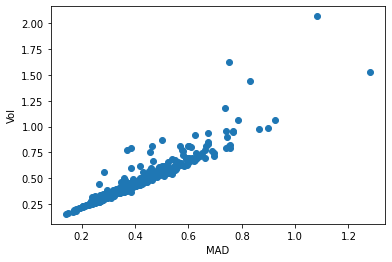

In [43]:
plt.scatter(data['1 Year MAD'],data['1 Year Volatility']);
plt.xlabel('MAD');
plt.ylabel('Vol');

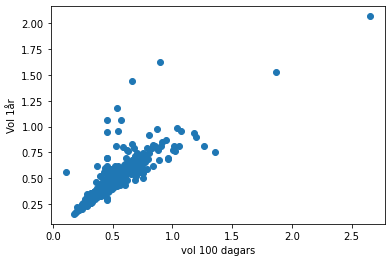

In [44]:
plt.scatter(data['Volatility']/100,data['1 Year Volatility']);
plt.xlabel('vol 100 dagars');
plt.ylabel('Vol 1år');

In [45]:
data[['1 Year MAD', '1 Year Volatility']].corr()

,1 Year MAD,1 Year Volatility
1 Year MAD,1.00,0.92
1 Year Volatility,0.92,1.00


In [46]:
data_mom.sort_values(by='1 Year Volatility')[['Company','1 Year MAD', '1 Year Volatility' ]]

,Company,1 Year MAD,1 Year Volatility
18,Aligro Planet SPAC,0.38,0.09
161,Fastpartner D,0.08,0.09
115,Creaspac SPAC,0.09,0.10
7,ACQ Bure SPAC,0.10,0.12
111,Corem Property D,0.10,0.13
413,Telia Company,0.14,0.15
42,Axfood,0.15,0.16
103,Cloetta,0.17,0.18
1,AAK,0.18,0.18
412,Tele2 B,0.17,0.19


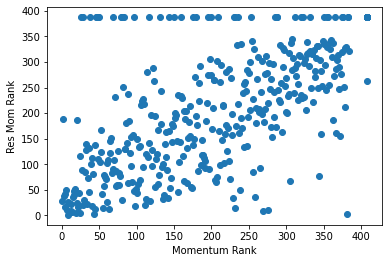

In [48]:
plt.scatter(momentum_tmp['1y Rank'],momentum_tmp['1y Res Mom Rank']);
plt.xlabel('Momentum Rank');
plt.ylabel('Res Mom Rank');

#### Correlation heat map between selected Ranks

In [49]:
#corr = data_mom[['3m Rank', '6m Rank', '1y Rank' , 'Momentum Rank', 'EA Std Rank', 'Volatility Rank']].corr()

corr = data[['Quality Rank', 'Value Rank', 'Momentum Rank', 'EA Std Rank', 'Triple Sort']].corr()



In [50]:
corr

,Quality Rank,Value Rank,Momentum Rank,EA Std Rank,Triple Sort
Quality Rank,1.00,0.71,0.37,0.20,0.86
Value Rank,0.71,1.00,0.34,0.15,0.85
Momentum Rank,0.37,0.34,1.00,0.59,0.71
EA Std Rank,0.20,0.15,0.59,1.00,0.39
Triple Sort,0.86,0.85,0.71,0.39,1.00


## Import data

In [43]:
#file_name =  "clean_data_2021-11-29.csv"
#folder = "../clean_equity_data/"
#data_tmp = pd.read_csv(folder + file_name)

In [52]:
momentum_tmp.sort_values(by='Res_Mom', ascending=False)[['Company', 'EA ret std','Res_Mom']].head(40)



,Company,EA ret std,Res_Mom
217,InDex Pharmaceuticals,1.94,0.80
70,Björn Borg,3.24,0.70
163,Fastpartner D,0.99,0.63
302,Nokia,-1.38,0.58
316,Ogunsen,-2.24,0.51
157,Fabege,-1.05,0.49
420,Tele2 B,-3.16,0.48
313,Nyfosa,1.17,0.47
38,AstraZeneca,-2.85,0.46
40,Atrium Ljungberg,-1.09,0.46


In [45]:

data_tmp[['EA ret std', 'Return 3m', 'Return 6m' , 'Return 1y', 'Res_Mom']].corr(method = 'spearman')


,EA ret std,Return 3m,Return 6m,Return 1y,Res_Mom
EA ret std,1.00,0.21,0.25,0.12,0.15
Return 3m,0.21,1.00,0.58,0.26,0.31
Return 6m,0.25,0.58,1.00,0.68,0.46
Return 1y,0.12,0.26,0.68,1.00,0.44
Res_Mom,0.15,0.31,0.46,0.44,1.00


In [63]:
opt = Optimize_Portfolio(data_mom[['EA Std Rank','3m Rank', '6m Rank' ,
                               '1y Rank', '1y Res Mom Rank']], objective = 'Kelly')

opt['x']

array([ 1.00892856e-02,  7.33941458e-03, -5.50093056e-13,  7.53107247e-03,
        6.44556152e-03])

In [46]:
#### 

In [47]:
import scipy.optimize as sco
import scipy

from sklearn.covariance import LedoitWolf


def Optimize_Portfolio(data ,risk_free = 0, objective = 'Kelly'):
    

    
    
    if objective == 'Kelly':  
        #ret = (data).prod()**(1/len(data)) - 1 #cagr
        ret = (data-1).mean()
        #cov = data.cov().to_numpy()
        cov_fit = LedoitWolf().fit(data)
        cov = cov_fit.covariance_
        
        #need smaller step size
        num_assets = ret.shape[0]
        args = (ret, cov,risk_free)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                      {'type':'ineq', 'fun': lambda x: 1 - np.sum(x)}) # sum <= 1
                      #{'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  
        
        
        result = sco.minimize(kelly_objective, num_assets*[1./num_assets,], args=args, 
                                  method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001) 
        
    elif objective == 'Sharpe':
        ret = (data-1).mean() 
      
        cov_fit = LedoitWolf().fit(data)
        cov = cov_fit.covariance_
        
        num_assets = ret.shape[0]
        args = (ret, cov,risk_free)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  
        result = sco.minimize(sharpe_objective, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001)
    
    elif objective == 'Max Div':
        num_assets = len(data.columns)
        #cov = data.cov().to_numpy()
        
        cov_fit = LedoitWolf().fit(data)
        cov = cov_fit.covariance_
        
        args = (cov)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
        
        result = sco.minimize(calc_diversification_ratio, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001)
        
    elif objective == "min var":
        num_assets = len(data.columns)
        
        
        cov_fit = LedoitWolf().fit(data)
        cov = cov_fit.covariance_
        
        args = (cov)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
        
        result = sco.minimize(port_var, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001)
    elif objective == "erc":
        num_assets = len(data.columns)
        #cov = data.cov().to_numpy()
        
        cov_fit = LedoitWolf().fit(data)
        cov = cov_fit.covariance_
        
        args = (cov)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
        
        result = sco.minimize(erc, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001)
        
        
        
    
    return (result)

def kelly_objective(weights,ret, cov, risk_free = 0):
    
    #kelly_ret = port_ret(weights, ret)
    kelly_ret = port_ret(weights, ret) - port_var(weights, cov)/2
    
    obj = -(kelly_ret)
    
    return(obj)

def sharpe_objective(weights,ret, cov, risk_free = 0):
    ret = port_ret(weights, ret)
    std = port_var(weights, cov)**(1/2)
    
    obj = - (ret/std)
    return(obj)


def port_var(weights, cov):
    var = weights.dot(cov).dot(weights)
    return(var)

def port_ret(weights, ret, risk_free = 0):
    #needs to be array
    ret = ret - risk_free
    port_ret = weights.dot(ret)
    return(port_ret)

def risk_parity(data):
    vol = np.log((data)).std()

    sum_vol = 0
    for i in range(len(vol)):
        sum_vol =sum_vol + (1/vol[i])
    
    weight = []
    for i in range(len(vol)):
        w = (1/vol[i])/(sum_vol)
        weight.append(w)
   
    weight = [round(num, 2) for num in weight]
    return(weight)


def calc_diversification_ratio(weights, cov):
    # average weighted vol
    w_vol = np.dot(np.sqrt(np.diag(cov)), weights.T)
    # portfolio vol
    port_vol = np.sqrt(port_var(weights, cov))
    
    diversification_ratio = w_vol/port_vol
    # return negative for minimization problem (maximize = minimize -)
    return -diversification_ratio

def erc(weights, cov):
        # these are non normalized risk contributions, i.e. not regularized
        # by total risk, seems to help numerically
        risk_contributions = np.dot(weights, cov) * weights
        a = np.reshape(risk_contributions, (len(risk_contributions), 1))
        # broadcasts so you get pairwise differences in risk contributions
        risk_diffs = a - a.transpose()
        sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
        # https://stackoverflow.com/a/36685019/1451311
        return sum_risk_diffs_squared #/ scale_factorcov

